# Create a Reference Model with `virtualizarr`

In this tutorial, we illustrate how to assemble a reference model from `.nc` files located in a remote `S3` bucket.
We will use the library `virtualizarr`, which allows us to conveniently concatenate and save the final dataset in the `parquet` format without loading in memory the data (with a function called [`openvirtual_dataset()`](https://virtualizarr.readthedocs.io/en/stable/generated/virtualizarr.backend.open_virtual_dataset.html#virtualizarr.backend.open_virtual_dataset)).


Here a summary of the main steps for building a reference model:

1. Identify where the raw data of your reference is stored. 
2. Copy the data to the (`S3`) bucket.
3. Unify the data to a single dataset and store it locally to a `parq/` folder (i.e., `parquet` format).
4. Optionally, upload the dataset on the remote bucket to share the model.

We will illustrate this guide with an example using the [Ocean Physics Analysis and Forecast model for the European North West Shelf](https://data.marine.copernicus.eu/product/NWSHELF_ANALYSISFORECAST_PHY_004_013/description).

We will assemble the following data from 2022 to 2023:
- _Sea surface height above geoid SSH_ (variable `zos`).
- _Sea Water Potential Temperature_ (variable `thetao`).
- _Bathymetry_ (sea bottom depth, variable `deptho`).
- _Sea-land mask_ (variable `mask`).

## 1.a. Find the raw data

First, we need to find where the raw data of the targeted reference model is stored.

Once you have identified the model you want to use, use [this web page](https://radiantearth.github.io/stac-browser/#/search/external/keewis-copernicus-marine.hf.space/?.language=en) to find the url of the data.
Enter/Search for the name of your model in the input ''Collections''.
Once you've submitted your search, different data will be listed, along with their respective time intervals.
In our case, we look for the <ins>hourly</ins> mean fields (and the additional static data _bathymetry_ and _land-sea mask_), which are located here:
- [`zos`](https://radiantearth.github.io/stac-browser/#/external/keewis-copernicus-marine.hf.space/collections/NWSHELF_ANALYSISFORECAST_PHY_004_013/items/cmems_mod_nws_phy_anfc_0.027deg-2D_PT1H-m_202411?.language=en).
- [`thetao`](https://radiantearth.github.io/stac-browser/#/external/keewis-copernicus-marine.hf.space/collections/NWSHELF_ANALYSISFORECAST_PHY_004_013/items/cmems_mod_nws_phy_anfc_0.027deg-3D_PT1H-m_202309?.language=en&.asset=asset-native).
- [`deptho` and `mask`](https://radiantearth.github.io/stac-browser/#/external/keewis-copernicus-marine.hf.space/collections/NWSHELF_ANALYSISFORECAST_PHY_004_013/items/cmems_mod_nws_phy_anfc_0.027deg-3D_static_202411--ext--bathy?.language=en).

We suggest using the native data, whose url can be copy-pasted under the panel  ''Native dataset'' in the ''Assets'' section (see screenshot below).
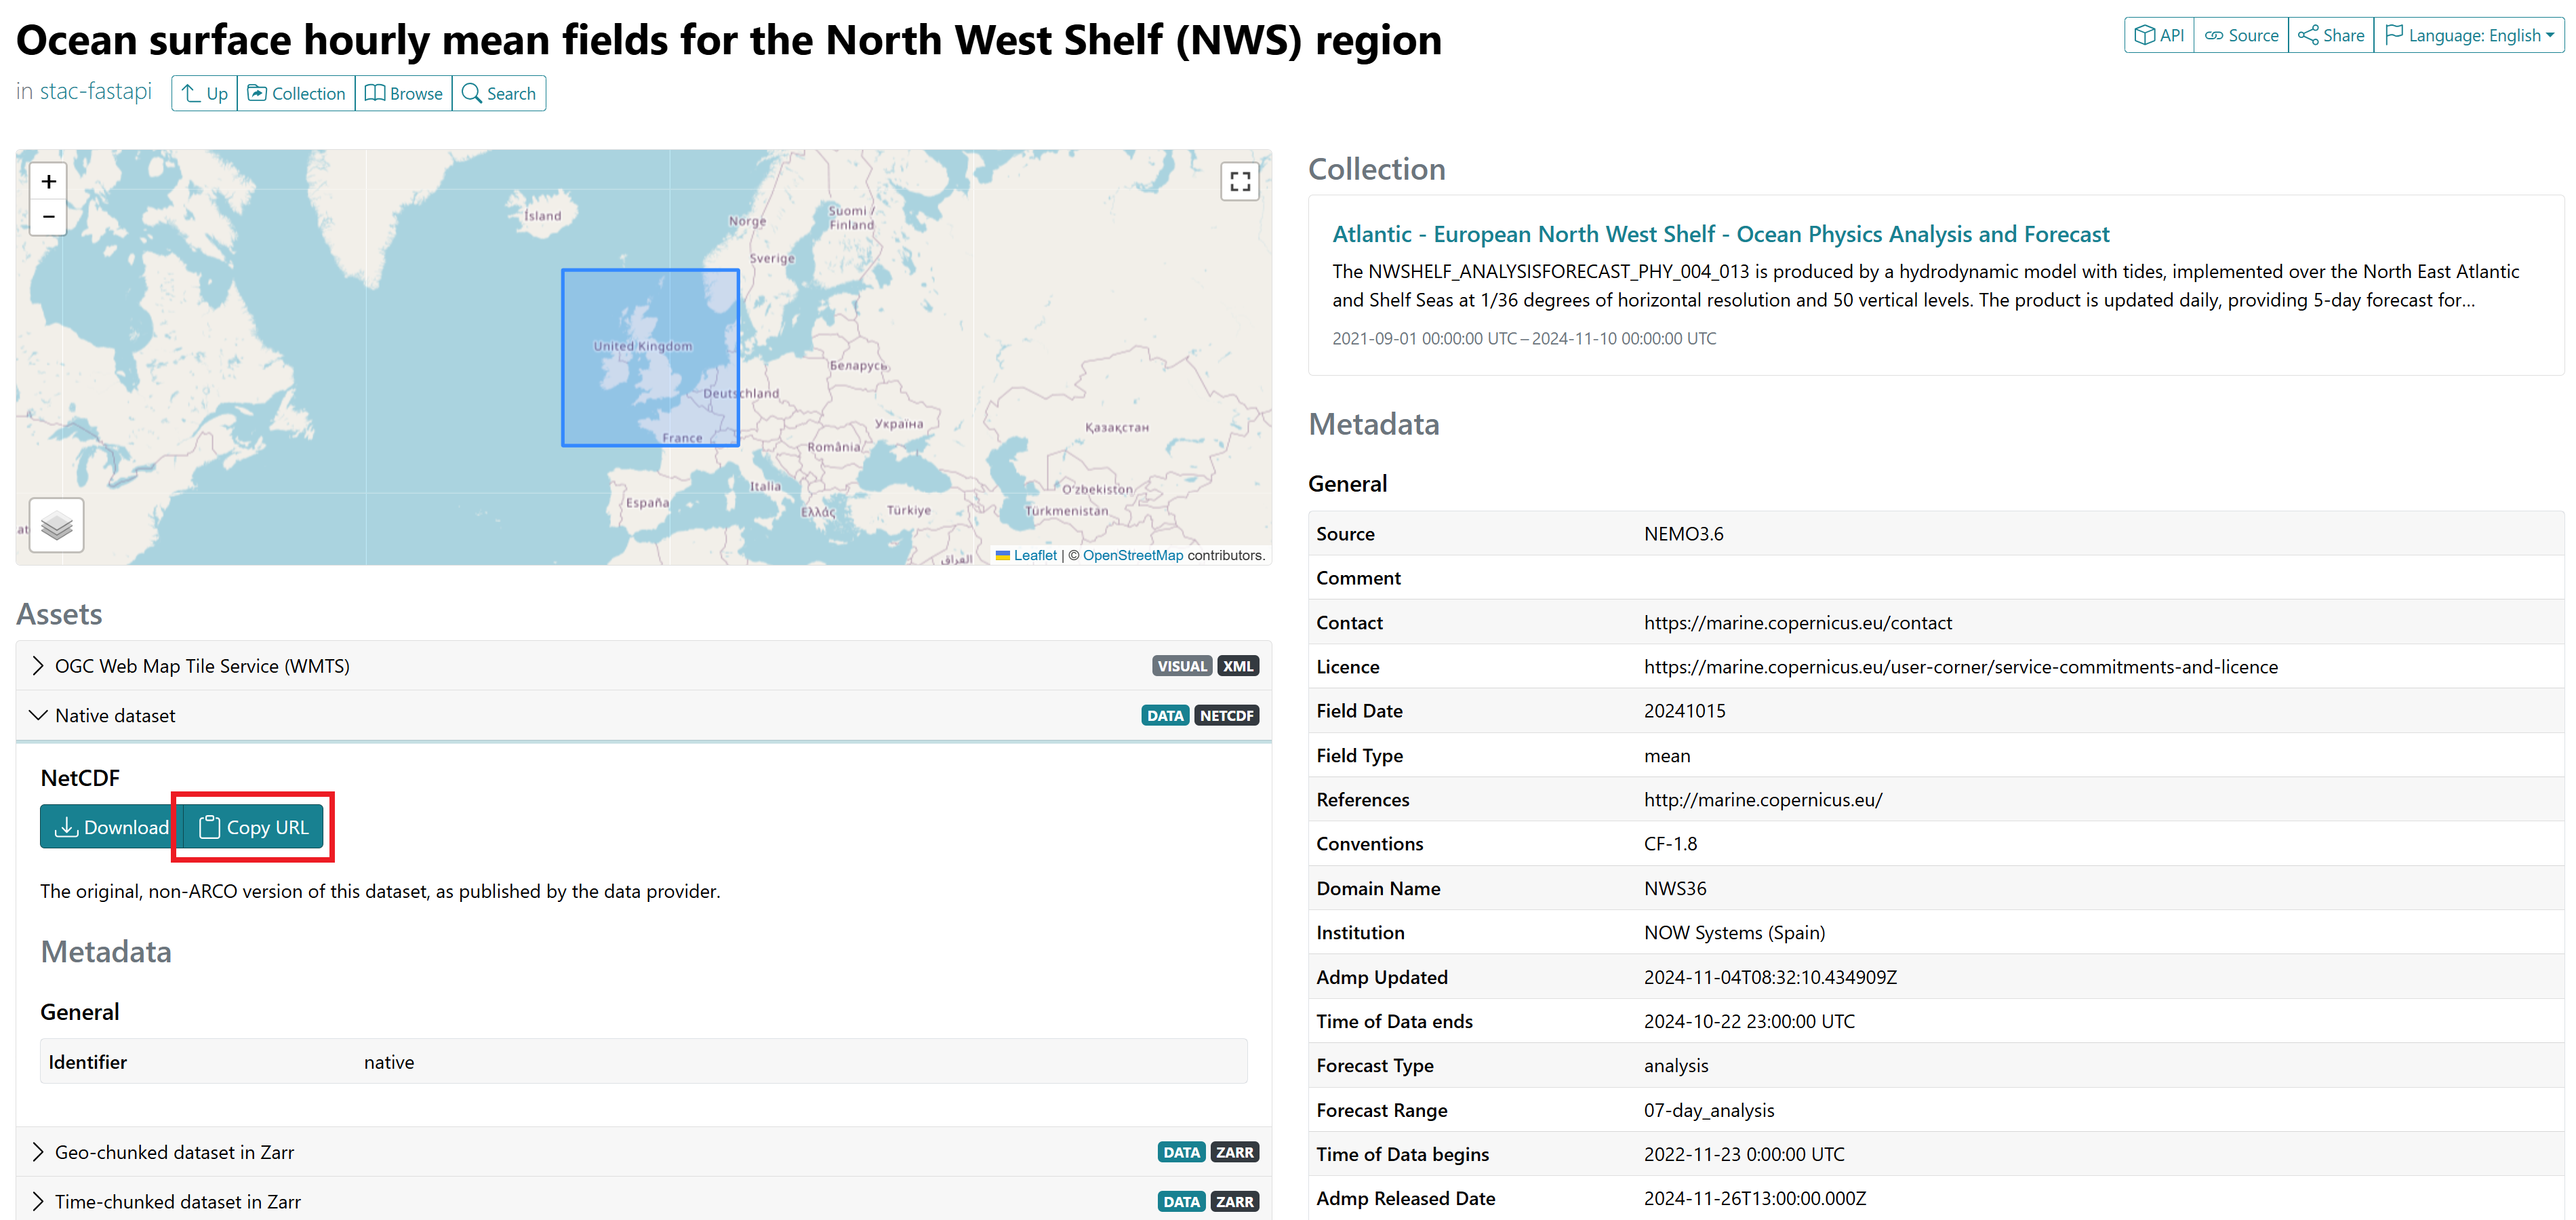


_Note: if you don't work remotely, feel free to download the files locally!_
_For our illustration though, we assume otherwise._

## 1.b. Fetch the data

We fetch the data with `rclone`. Ensure that you have the adequate credentials (check the file `~/.config/rclone/rclone.conf` with `cat`)*.

*_For GFTS users, it should be done automatically during your onboarding._

Adapt and execute the following command:
```
rclone copy cmarine:SRC_URL gfts:DEST_URL
```
Where `SRC_URL` is the url copy-pasted earlier and `DEST_URL` the path where you want to store the data on the GFTS bucket, for each url.

In our example, it corresponds to:
```
rclone copy cmarine:mdl-native-13/native/NWSHELF_ANALYSISFORECAST_PHY_004_013/cmems_mod_nws_phy_anfc_0.027deg-2D_PT1H-m_202411 gfts:gfts-reference-data/demo/NWSHELF_ANALYSISFORECAST_PHY_004_013/
rclone copy cmarine:mdl-native-13/native/NWSHELF_ANALYSISFORECAST_PHY_004_013/cmems_mod_nws_phy_anfc_0.027deg-3D_PT1H-m_202309 gfts:gfts-reference-data/demo/NWSHELF_ANALYSISFORECAST_PHY_004_013/
rclone copy cmarine:mdl-native-13/native/NWSHELF_ANALYSISFORECAST_PHY_004_013/cmems_mod_nws_phy_anfc_0.027deg-3D_static_202411/NWS-MFC_004_013_mask_bathy.nc gfts:gfts-reference-data/demo/NWSHELF_ANALYSISFORECAST_PHY_004_013/
```

## 2. Assembling The Model

### Preliminaries

The idea is simple, and consists in those steps **for each path/data source**:
1. Open virtually (i.e., without loading data in memory) all the `.nc` files.
2. Depending on your application, post-process the datasets (e.g., dropping or renaming variables or coordinates).
3. Concatenate them along time.

Then, we `merge` all the concatenated data and store the resulting dataset with `kerchunk` in the `parquet` format (usually, under a `*.parq/` folder).

Below, we first present how to setup the notebook (installing the package, defining different variables etc.).
Next, we show how to generally perform the steps above.
Finally, we implement them to our example.

### Setup
As mentioned earlier, we rely on the `virtualizarr` library and its function `open_virtual_dataset` for opening the remote datasets.

First, install `virtualizarr` with `pip` and import the function `open_virtual_dataset`:

In [11]:
!pip install virtualizarr

Import the `open_virtual_dataset` function and configure the remote access to the S3 bucket.

In [38]:
from virtualizarr import open_virtual_dataset
import s3fs
import xarray as xr

s3 = s3fs.S3FileSystem(
    anon=False,
    profile="gfts",
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
        "region_name": "gra",
    },
)
storage_options = {
    "anon": False,
    "client_kwargs": {
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net/",
        "region_name": "gra",
    },
} # for opening remote virtual dataset with virtualizarr

### How-to General Procedure

#### Open virtually the `.nc` files given a remote `root` folder
```python
root = "path_of_your_data_on_s3/" # update w.r.t your use case
s3path = f"{root}*.nc"            # update w.r.t your use case

remote_files = sorted(s3.glob(s3path)) # remind to sort (time-wise) the files!

virtual_datasets = [
    open_virtual_dataset(
        "s3://" + filepath, 
        reader_options={"storage_options": storage_options},
        indexes={}, # we will concatenate the datasets along time later 
        decode_times=True,
        # indicate here the variables/coords you want to load in memory
        # by doing so they will be **saved** in the final `.parq/` folder
        loadable_variables=["depth", "longitude", "latitude"]
    )
    for filepath in remote_files
]
```

#### Concatenating the `vds` along time
```python
vds = xr.concat(virtual_datasets, dim="time", compat="override", coords="minimal", data_vars="minimal", combine_attrs="drop_conflicts")
```

Repeat the procedure for each `root` path (or data source).
Now, assuming you end up with, for instance, `vds1` and `vds2`, here how to merge them before saving the result:
```python
import xarray as xr
merged_vds = xr.merge([vds1, vds2])
merged_vds.virtualize.to_kerchunk("output.parq", format="parquet") # update w.r.t your application
```

_NB: if you only have a source (i.e., a single `vds`), skip the mergging step and directly run `vds.virtualize.to_kerchunk("output.parq", format="parquet")`._

### Speeding up the computation with `dask`
The opening of the remote files can be speeded up with `dask` as follows:

Creates a local cluster
```python
from distributed import LocalCluster
import dask
cluster = LocalCluster()
client = cluster.get_client()
client
```

Then, embed the calls to `open_virtual_dataset` with `dask.delayed(...)` and lunch the computation with `dask.compute()`.
```python
...
virtual_datasets = [
    dask.delayed(open_virtual_dataset)(
        "s3://" + filepath, 
        ...
    )
    for filepath in remote_files
]
vds = dask.compute(*virtual_datasets)
...
```

Not only it speeds up the computation, but it also lets you follow the progression (something very helpful if there are a lot of `.nc` files to read).

### Application: Example
We finish this how-to guide by implementing the procedure above to our example.

Let's first define variables to store the `root` paths of each data source:

In [1]:
# data sources
root = "gfts-reference-data/demo/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/"
static_root = root + "cmems_mod_nws_phy_anfc_0.027deg-3D_static_202411/"
ssh_root = root + "cmems_mod_nws_phy_anfc_0.027deg-2D_PT1H-m_202411/"
temp_root = root + "cmems_mod_nws_phy_anfc_0.027deg-3D_PT1H-m_202309/"

In [39]:
# creates a cluster to speed up the computation 
from distributed import LocalCluster
import dask
cluster = LocalCluster()
client = cluster.get_client()
client

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35019 instead
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:1617: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| numpy   | 2.1.3  | 2.1.3     | 2.0.2   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35019/status,
Dashboard: http://127.0.0.1:35019/status,Workers: 3
Total threads: 6,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36717,Workers: 3
Dashboard: http://127.0.0.1:35019/status,Total threads: 6
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:44673,Total threads: 2
Dashboard: http://127.0.0.1:44217/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:37825,


#### Static data (`mask` and `deptho`)

In [13]:
# locates the `.nc` file 
s3path = f"{static_root}*_mask_bathy.nc"
remote_files = s3.glob(s3path)
assert len(remote_files) == 1
print(f"found {len(remote_files)} .nc files.")
print(remote_files)

found 1 .nc files.
['gfts-reference-data/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/MetO-NWS-PHY-001-013-STATIC_202112/NWS-MFC_004_013_mask_bathy.nc']


In [14]:
# opens the virtual dataset while dropping unused variables
vds = open_virtual_dataset(
        "s3://" + remote_files[0], 
        reader_options={"storage_options": storage_options},
        indexes={}, 
        decode_times=True, 
        loadable_variables=["depth", "longitude", "latitude"]
).drop_vars(["lat", "lon", "deptho_lev_interp"]).rename_dims({"latitude": "lat", "longitude": "lon"})
vds

<xarray.Dataset> Size: 162MB
Dimensions:    (lat: 1240, lon: 958, depth: 33)
Coordinates:
  * depth      (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * latitude   (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.72 62.73 62.74
  * longitude  (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
Dimensions without coordinates: lat, lon
Data variables:
    deptho     (lat, lon) float32 5MB ManifestArray<shape=(1240, 958), dtype=...
    mask       (depth, lat, lon) float32 157MB ManifestArray<shape=(33, 1240,...
Attributes:
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2021-10-26T06:41:01Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    institution:          UK Met Office
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...

Explanations:
- We want to work with `lat` and `lon` coordinates. However, no all the datasets use the same names (`longitude` vs `lon`). So, along with `deptho_lev_interp`, we remove `lat` and `lon` (if any) and then rename `latitude` and `longitude` to `lat` and `lon`, respectively. 

In [51]:
static_vds = vds.rename({"latitude": "lat", "longitude": "lon"})
static_vds

/tmp/ipykernel_374/3887474104.py:1: UserWarning: rename 'latitude' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  static_vds = vds.rename({"latitude": "lat", "longitude": "lon"})
/tmp/ipykernel_374/3887474104.py:1: UserWarning: rename 'longitude' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  static_vds = vds.rename({"latitude": "lat", "longitude": "lon"})


<xarray.Dataset> Size: 162MB
Dimensions:  (lat: 1240, lon: 958, depth: 33)
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
Data variables:
    deptho   (lat, lon) float32 5MB ManifestArray<shape=(1240, 958), dtype=fl...
    mask     (depth, lat, lon) float32 157MB ManifestArray<shape=(33, 1240, 9...
Attributes:
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2021-10-26T06:41:01Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    institution:          UK Met Office
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...

####  Sea Surface Height (`zos`)

In [41]:
remote_files = sorted(
    s3.glob(f"{ssh_root}2022/*/*.nc") + 
    s3.glob(f"{ssh_root}2023/*/*.nc")
)
print(f"found {len(remote_files)} .nc files.")

found 743 .nc files.


In [42]:
zos_virtual_datasets = [
    dask.delayed(open_virtual_dataset)(
        "s3://" + filepath, 
        reader_options={"storage_options": storage_options}, 
        indexes={}, 
        decode_times=True, 
        loadable_variables=["time", "lat", "lon"]
    )
    for filepath in remote_files
]

In [43]:
zvds = dask.compute(*zos_virtual_datasets)

In [44]:
zos_vds = xr.concat(zvds, dim="time", compat="override", coords="minimal", data_vars="minimal", combine_attrs="drop_conflicts") 

In [45]:
zos_vds

<xarray.Dataset> Size: 42GB
Dimensions:  (time: 17832, lat: 1240, lon: 958)
Coordinates:
  * time     (time) datetime64[ns] 143kB 2022-01-01T01:00:00 ... 2024-01-14
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
Data variables:
    zos      (time, lat, lon) int16 42GB ManifestArray<shape=(17832, 1240, 95...
Attributes:
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    history:              See source and creation_date attributes
    institution:          UK Met Office
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous SSH (2D)

#### Sea Water Potential Temperature (`thetao`)

In [55]:
thetao_virtual_datasets = [
    dask.delayed(open_virtual_dataset)(
        "s3://" + filepath, 
        reader_options={"storage_options": storage_options}, 
        indexes={}, 
        decode_times=True, 
        loadable_variables=["time", "lat", "lon", "depth"] # note that we also load (and thus save) the depths
    )
    for filepath in sorted(
        s3.glob(f"{temp_root}2022/*/*.nc") + 
        s3.glob(f"{temp_root}2023/*/*.nc")
    )
]

In [56]:
tvds = dask.compute(*thetao_virtual_datasets)

In [57]:
thetao_vds = xr.concat(tvds, dim="time", compat="override", coords="minimal", data_vars="minimal", combine_attrs="drop_conflicts")

In [58]:
thetao_vds

<xarray.Dataset> Size: 1TB
Dimensions:  (time: 17832, depth: 33, lat: 1240, lon: 958)
Coordinates:
  * time     (time) datetime64[ns] 143kB 2022-01-01T01:00:00 ... 2024-01-14
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
Data variables:
    thetao   (time, depth, lat, lon) int16 1TB ManifestArray<shape=(17832, 33...
Attributes:
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    history:              See source and creation_date attributes
    institution:          UK Met Office
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    title:                hourly-instantaneous potential temperature (3D)

#### Merging the three data sources

In [59]:
merged_vds = xr.merge([static_vds, zos_vds, thetao_vds])

In [60]:
merged_vds.virtualize.to_kerchunk("combined_final.parq", format="parquet")

In [61]:
merged_vds

<xarray.Dataset> Size: 1TB
Dimensions:  (lat: 1240, lon: 958, depth: 33, time: 17832)
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 143kB 2022-01-01T01:00:00 ... 2024-01-14
Data variables:
    deptho   (lat, lon) float32 5MB ManifestArray<shape=(1240, 958), dtype=fl...
    mask     (depth, lat, lon) float32 157MB ManifestArray<shape=(33, 1240, 9...
    zos      (time, lat, lon) int16 42GB ManifestArray<shape=(17832, 1240, 95...
    thetao   (time, depth, lat, lon) int16 1TB ManifestArray<shape=(17832, 33...
Attributes: (12/13)
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2021-10-26T06:41:01Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    ...                   ...
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    coordinates:          depth lat lon time

#### Option: copy the model to S3

As before, we can use `rclone` to send the model to the bucket:
```
rclone copy combined_all.parq gfts:gfts-reference-data/demo/NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/
```

## Fixing `virtualizarr` *bug* and quick data checking

In the following, we show how to fix a shortcoming of `virtualizarr` which causes the first `depth` value to equal `nan` upon opening the dataset.

We conclude with some ways to quickly check that the your model is complete.

In [9]:
import xarray as xr

In [10]:
# not needed if already done
from distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39135 instead
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:1617: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| numpy   | 2.1.3  | 2.1.3     | 2.0.2   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39135/status,
Dashboard: http://127.0.0.1:39135/status,Workers: 3
Total threads: 6,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37137,Workers: 3
Dashboard: http://127.0.0.1:39135/status,Total threads: 6
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:36779,Total threads: 2
Dashboard: http://127.0.0.1:37619/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:35173,


In [ ]:
combined_ds = xr.open_dataset("combined_final.parq", engine="kerchunk", chunks={}) # chunks implicitly calls `dask`

In [12]:
combined_ds.coords["depth"].values[0] = 0. # fixing 1st depth is nan

In [13]:
combined_ds

<xarray.Dataset> Size: 3TB
Dimensions:  (depth: 33, lat: 1240, lon: 958, time: 8760)
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 70kB 2022-01-01T01:00:00 ... 2023-01-01
Data variables:
    deptho   (lat, lon) float32 5MB dask.array<chunksize=(620, 479), meta=np.ndarray>
    mask     (depth, lat, lon) float32 157MB dask.array<chunksize=(33, 1240, 958), meta=np.ndarray>
    mdt      (lat, lon) float32 5MB dask.array<chunksize=(1240, 958), meta=np.ndarray>
    thetao   (time, depth, lat, lon) float64 3TB dask.array<chunksize=(1, 11, 414, 320), meta=np.ndarray>
    zos      (time, lat, lon) float64 83GB dask.array<chunksize=(1, 1240, 958), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2021-10-26T06:41:01Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    institution:          UK Met Office
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...

#### Data checking

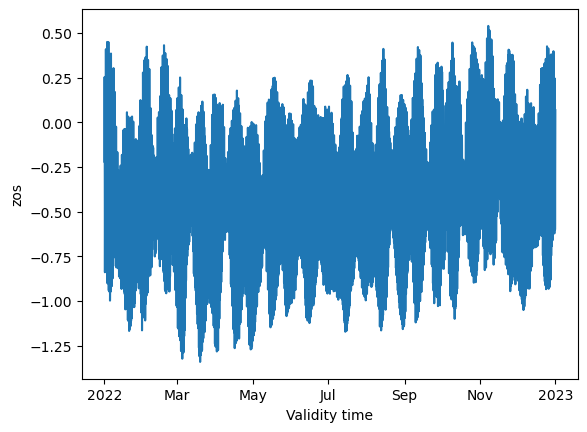

In [9]:
combined_ds.zos.mean(dim=["lon", "lat"]).plot()

##### Counting the data

In [15]:
combined_ds.sel(time="2022-01") # 743 values along time

<xarray.Dataset> Size: 240GB
Dimensions:  (depth: 33, lat: 1240, lon: 958, time: 743)
Coordinates:
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * time     (time) datetime64[ns] 6kB 2022-01-01T01:00:00 ... 2022-01-31T23:...
Data variables:
    deptho   (lat, lon) float32 5MB dask.array<chunksize=(620, 479), meta=np.ndarray>
    mask     (depth, lat, lon) float32 157MB dask.array<chunksize=(33, 1240, 958), meta=np.ndarray>
    mdt      (lat, lon) float32 5MB dask.array<chunksize=(1240, 958), meta=np.ndarray>
    thetao   (time, depth, lat, lon) float64 233GB dask.array<chunksize=(1, 11, 414, 320), meta=np.ndarray>
    zos      (time, lat, lon) float64 7GB dask.array<chunksize=(1, 1240, 958), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.7
    contact:              servicedesk.cmems@mercator-ocean.eu
    creation_date:        2021-10-26T06:41:01Z
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    history:              See source and creation_date attributes
    institution:          UK Met Office
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    netcdf-version-id:    netCDF-4
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    references:           http://marine.copernicus.eu/
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...

In [7]:
# sums over lon and lat and compare the number of values to the one above
count = combined_ds.zos.sel(time="2022-01").mean(dim=["lon", "lat"]).count().compute() # 743 too

In [8]:
count

<xarray.DataArray 'zos' ()> Size: 8B
np.int64(743)